In [356]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]= (20,10)

# *Data Cleaning*

In [382]:
df = pd.read_csv("/Users/dell/Downloads/zameen.csv")
df.head()

,City,Location,Price,Bedrooms,Baths,Area
0,Lahore,"DHA Phase 6, DHA Defence, Lahore",74500000,5,6,4500
1,Lahore,"DHA Phase 7, DHA Defence, Lahore",51500000,5,6,4500
2,Lahore,"Dream Gardens, Defence Road, Lahore",7500000,1,1,518
3,Lahore,"DHA Phase 6, DHA Defence, Lahore",73000000,5,6,4500
4,Lahore,"Bahria Town - Sector B, Bahria Town, Lahore",5700000,1,1,472


In [383]:
df['Price_in_Crore'] = df['Price'] / 10000000
df.head(5)

,City,Location,Price,Bedrooms,Baths,Area,Price_in_Crore
0,Lahore,"DHA Phase 6, DHA Defence, Lahore",74500000,5,6,4500,7.45
1,Lahore,"DHA Phase 7, DHA Defence, Lahore",51500000,5,6,4500,5.15
2,Lahore,"Dream Gardens, Defence Road, Lahore",7500000,1,1,518,0.75
3,Lahore,"DHA Phase 6, DHA Defence, Lahore",73000000,5,6,4500,7.30
4,Lahore,"Bahria Town - Sector B, Bahria Town, Lahore",5700000,1,1,472,0.57


# *Feature Engineering*

In [384]:
df['Price_per_Sqft'] = df['Price']/df['Area']
df.head()

,City,Location,Price,Bedrooms,Baths,Area,Price_in_Crore,Price_per_Sqft
0,Lahore,"DHA Phase 6, DHA Defence, Lahore",74500000,5,6,4500,7.45,16555.555556
1,Lahore,"DHA Phase 7, DHA Defence, Lahore",51500000,5,6,4500,5.15,11444.444444
2,Lahore,"Dream Gardens, Defence Road, Lahore",7500000,1,1,518,0.75,14478.764479
3,Lahore,"DHA Phase 6, DHA Defence, Lahore",73000000,5,6,4500,7.30,16222.222222
4,Lahore,"Bahria Town - Sector B, Bahria Town, Lahore",5700000,1,1,472,0.57,12076.271186


In [385]:
df.Location = df.Location.apply(lambda x: x.strip())
Location_stats = df.groupby('Location')['Location'].agg('count').sort_values(ascending=False)
Location_stats

Location
DHA Villas,  DHA Defence, Multan                            481
Citi Housing Society,  Gujranwala, Gujranwala               453
Bahria Town Phase 8,  Bahria Town Rawalpindi, Rawalpindi    432
Warsak Road,  Peshawar, Peshawar                            345
DHA Defence,  Gujranwala, Gujranwala                        343
                                                           ... 
Khyber Colony 2,  Peshawar, Peshawar                          1
Kings Garden,  Gulistan-e-Jauhar, Karachi                     1
Kings Tower,  Gulistan-e-Jauhar - Block 15, Karachi           1
Kings Town,  Raiwind Road, Lahore                             1
Zubair Colony,  Faisalabad, Faisalabad                        1
Name: Location, Length: 2035, dtype: int64

In [386]:
Location_stats_less_then_10 = Location_stats[Location_stats<=10]
Location_stats_less_then_10

Location
Islamabad Square,  MPCHS - Multi Gardens, Islamabad          10
Gulistan-e-Jauhar - Block 2,  Gulistan-e-Jauhar, Karachi     10
Gulistan-e-Jauhar - Block 15,  Gulistan-e-Jauhar, Karachi    10
Canal Vista,  Warsak Road, Peshawar                          10
Gulistan-e-Jauhar - Block 14,  Gulistan-e-Jauhar, Karachi    10
                                                             ..
Khyber Colony 2,  Peshawar, Peshawar                          1
Kings Garden,  Gulistan-e-Jauhar, Karachi                     1
Kings Tower,  Gulistan-e-Jauhar - Block 15, Karachi           1
Kings Town,  Raiwind Road, Lahore                             1
Zubair Colony,  Faisalabad, Faisalabad                        1
Name: Location, Length: 1747, dtype: int64

In [387]:
df.Location = df.Location.apply(lambda x: 'other' if x in Location_stats_less_then_10 else x)
len(df.Location.unique())

289

# *Removing Outlier*

In [388]:
df[df.Area/df.Bedrooms<300].head()

,City,Location,Price,Bedrooms,Baths,Area,Price_in_Crore,Price_per_Sqft
12,Lahore,other,8000000,3,3,562,0.80,14234.875445
20,Lahore,"Al-Kabir Town - Phase 2, Al-Kabir Town, Lahore",17500000,4,5,1125,1.75,15555.555556
23,Lahore,other,16500000,5,6,1125,1.65,14666.666667
26,Lahore,"Johar Town, Lahore, Lahore",29000000,5,5,1125,2.90,25777.777778
28,Lahore,"Johar Town Phase 2, Johar Town, Lahore",29000000,5,6,1125,2.90,25777.777778


In [389]:
df = df[~(df.Area/df.Bedrooms<300)]
df.shape

(13216, 8)

In [390]:
df = df[~(df.Price_per_Sqft<5000)]
df = df[~(df.Price_per_Sqft>40000)]
df.shape

(12570, 8)

In [391]:
df.Price_per_Sqft.describe()

count    12570.000000
mean     15394.297876
std       6268.308278
min       5000.000000
25%      10864.197531
50%      14444.444444
75%      18222.222222
max      40000.000000
Name: Price_per_Sqft, dtype: float64

In [392]:
def remove_room_outlier(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('Location'):
        room_stats = {}
        for room, room_df in location_df.groupby('Bedrooms'):
            room_stats[room] = {
                'mean' : np.mean(room_df.Price_per_Sqft),
                'std' : np.std(room_df.Price_per_Sqft),
                'count' : room_df.shape[0]
            }
        for room, room_df in location_df.groupby('Bedrooms'):
            stats = room_stats.get(room-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, room_df[room_df.Price_per_Sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df = remove_room_outlier(df)
df

,City,Location,Price,Bedrooms,Baths,Area,Price_in_Crore,Price_per_Sqft
2,Lahore,other,7500000,1,1,518,0.75,14478.764479
5,Lahore,other,53500000,5,6,2250,5.35,23777.777778
6,Lahore,"Bahria Town - Overseas A, Bahria Town - Overs...",97500000,5,6,4500,9.75,21666.666667
7,Lahore,"Bahria Town - Jasmine Block, Bahria Town - Se...",47000000,5,7,4500,4.70,10444.444444
8,Lahore,"Bahria Town - Sector E, Bahria Town, Lahore",5000000,1,1,450,0.50,11111.111111
...,...,...,...,...,...,...,...,...
15887,2_FECHS,"FECHS, E-11/2, 2_FECHS",70000000,9,10,4500,7.00,15555.555556
15888,2_FECHS,"FECHS, E-11/2, 2_FECHS",62500000,8,9,4500,6.25,13888.888889
15889,2_FECHS,"FECHS, E-11/2, 2_FECHS",61000000,8,9,4500,6.10,13555.555556
15890,2_FECHS,"FECHS, E-11/2, 2_FECHS",60000000,8,9,4500,6.00,13333.333333


Text(0, 0.5, 'Count')

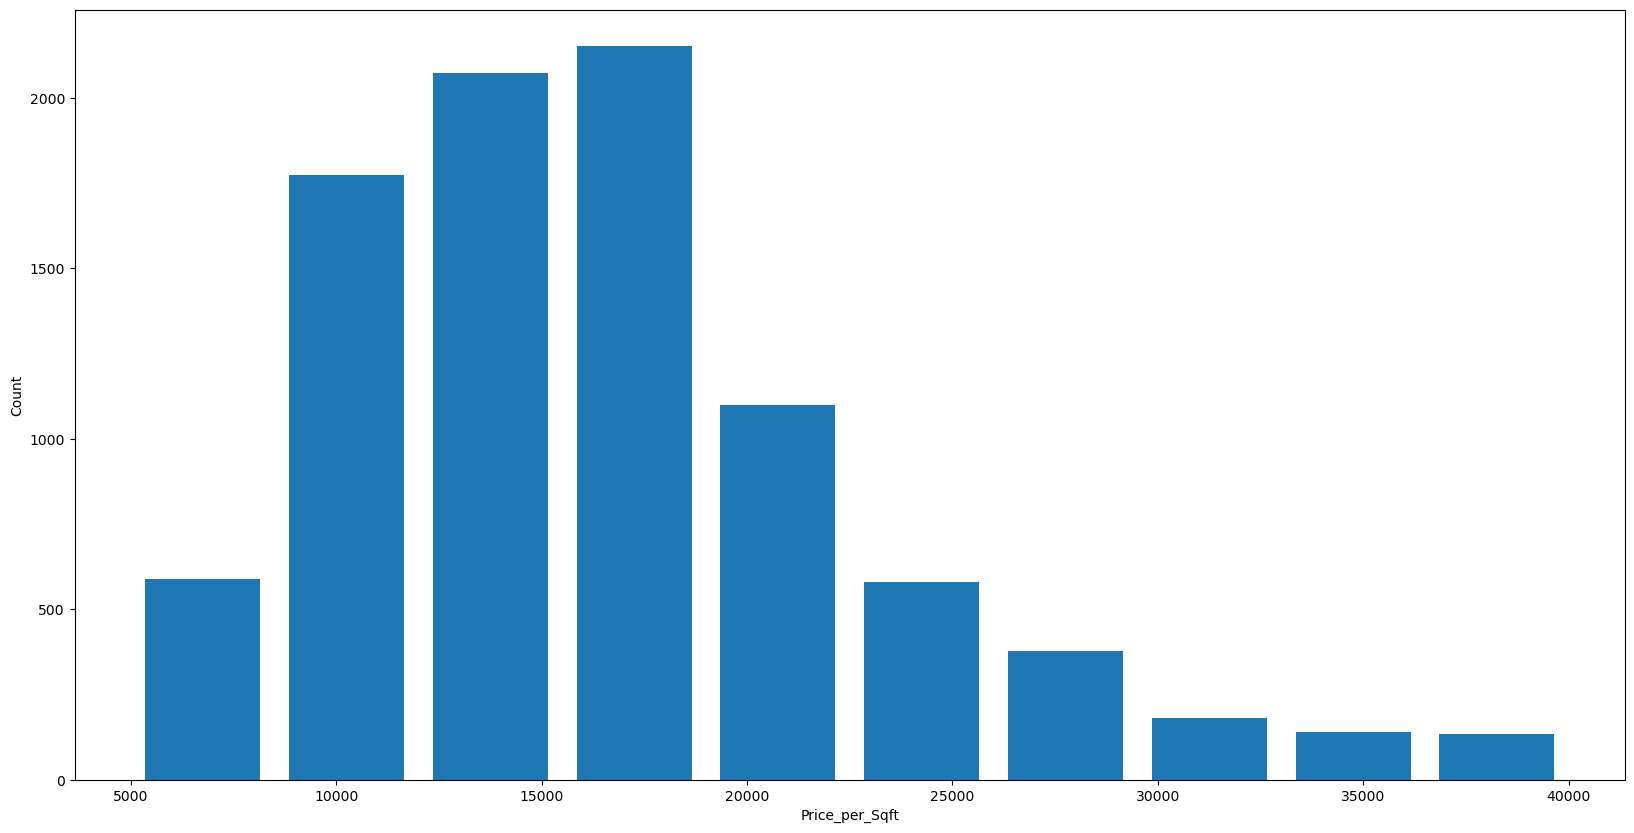

In [393]:
matplotlib.rcParams['figure.figsize'] = (20,10)
plt.hist(df.Price_per_Sqft,rwidth=0.8)
plt.xlabel('Price_per_Sqft')
plt.ylabel('Count')

In [394]:
df = df[df.Baths<df.Bedrooms+2]
df

,City,Location,Price,Bedrooms,Baths,Area,Price_in_Crore,Price_per_Sqft
2,Lahore,other,7500000,1,1,518,0.75,14478.764479
5,Lahore,other,53500000,5,6,2250,5.35,23777.777778
6,Lahore,"Bahria Town - Overseas A, Bahria Town - Overs...",97500000,5,6,4500,9.75,21666.666667
8,Lahore,"Bahria Town - Sector E, Bahria Town, Lahore",5000000,1,1,450,0.50,11111.111111
10,Lahore,"DHA Phase 6, DHA Defence, Lahore",95000000,6,7,4500,9.50,21111.111111
...,...,...,...,...,...,...,...,...
15887,2_FECHS,"FECHS, E-11/2, 2_FECHS",70000000,9,10,4500,7.00,15555.555556
15888,2_FECHS,"FECHS, E-11/2, 2_FECHS",62500000,8,9,4500,6.25,13888.888889
15889,2_FECHS,"FECHS, E-11/2, 2_FECHS",61000000,8,9,4500,6.10,13555.555556
15890,2_FECHS,"FECHS, E-11/2, 2_FECHS",60000000,8,9,4500,6.00,13333.333333


In [395]:
df.Price_per_Sqft.describe()


count     8819.000000
mean     16433.633313
std       6518.789993
min       5000.000000
25%      11565.836299
50%      15555.555556
75%      19296.494730
max      40000.000000
Name: Price_per_Sqft, dtype: float64

# *Model Building*

In [396]:
dummies = pd.get_dummies(df.Location)
dummies.head(3)

,"201 Apartment, Murree Expressway, Murree","Abdullah Gardens, East Canal Road, Faisalabad","Acantilado Commercial, Bahria Town Phase 7, Rawalpindi","Adiala Road, Rawalpindi, Rawalpindi","Airport Housing Society - Sector 4, Airport Housing Society, Rawalpindi","Airport Housing Society, Rawalpindi, Rawalpindi","Al Karim Residence, H-13, Islamabad","Al Noor Garden, Faisalabad, Faisalabad","Al Rehman Garden Phase 2, Al Rehman Garden, Lahore","Al-Ahad Heights, Defence Road, Rawalpindi",...,"Wapda City, Faisalabad, Faisalabad","Wapda Town Phase 1 - Block E, Wapda Town Phase 1, Multan","Wapda Town Phase 1, Wapda Town, Multan","Wapda Town Phase 2, Wapda Town, Multan","Wapda Town, Gujranwala, Gujranwala","Wapda Town, Multan, Multan","Wapda Town, Peshawar, Peshawar","Warsak Road, Peshawar, Peshawar","Zakariya Town, Multan, Multan",other
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [397]:
df0 = pd.concat([df,dummies.drop('other',axis='columns')],axis='columns')
df0.head(3)

,City,Location,Price,Bedrooms,Baths,Area,Price_in_Crore,Price_per_Sqft,"201 Apartment, Murree Expressway, Murree","Abdullah Gardens, East Canal Road, Faisalabad",...,"Wapda City - Block K, Wapda City, Faisalabad","Wapda City, Faisalabad, Faisalabad","Wapda Town Phase 1 - Block E, Wapda Town Phase 1, Multan","Wapda Town Phase 1, Wapda Town, Multan","Wapda Town Phase 2, Wapda Town, Multan","Wapda Town, Gujranwala, Gujranwala","Wapda Town, Multan, Multan","Wapda Town, Peshawar, Peshawar","Warsak Road, Peshawar, Peshawar","Zakariya Town, Multan, Multan"
2,Lahore,other,7500000,1,1,518,0.75,14478.764479,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Lahore,other,53500000,5,6,2250,5.35,23777.777778,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Lahore,"Bahria Town - Overseas A, Bahria Town - Overs...",97500000,5,6,4500,9.75,21666.666667,0,0,...,0,0,0,0,0,0,0,0,0,0


In [398]:
df01 = df0.drop(['City','Location','Price','Price_per_Sqft'],axis='columns')
df01.head(3)

,Bedrooms,Baths,Area,Price_in_Crore,"201 Apartment, Murree Expressway, Murree","Abdullah Gardens, East Canal Road, Faisalabad","Acantilado Commercial, Bahria Town Phase 7, Rawalpindi","Adiala Road, Rawalpindi, Rawalpindi","Airport Housing Society - Sector 4, Airport Housing Society, Rawalpindi","Airport Housing Society, Rawalpindi, Rawalpindi",...,"Wapda City - Block K, Wapda City, Faisalabad","Wapda City, Faisalabad, Faisalabad","Wapda Town Phase 1 - Block E, Wapda Town Phase 1, Multan","Wapda Town Phase 1, Wapda Town, Multan","Wapda Town Phase 2, Wapda Town, Multan","Wapda Town, Gujranwala, Gujranwala","Wapda Town, Multan, Multan","Wapda Town, Peshawar, Peshawar","Warsak Road, Peshawar, Peshawar","Zakariya Town, Multan, Multan"
2,1,1,518,0.75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,6,2250,5.35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,5,6,4500,9.75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [399]:
df01.shape

(8819, 289)

In [400]:
x = df01.drop('Price_in_Crore',axis='columns')
x

,Bedrooms,Baths,Area,"201 Apartment, Murree Expressway, Murree","Abdullah Gardens, East Canal Road, Faisalabad","Acantilado Commercial, Bahria Town Phase 7, Rawalpindi","Adiala Road, Rawalpindi, Rawalpindi","Airport Housing Society - Sector 4, Airport Housing Society, Rawalpindi","Airport Housing Society, Rawalpindi, Rawalpindi","Al Karim Residence, H-13, Islamabad",...,"Wapda City - Block K, Wapda City, Faisalabad","Wapda City, Faisalabad, Faisalabad","Wapda Town Phase 1 - Block E, Wapda Town Phase 1, Multan","Wapda Town Phase 1, Wapda Town, Multan","Wapda Town Phase 2, Wapda Town, Multan","Wapda Town, Gujranwala, Gujranwala","Wapda Town, Multan, Multan","Wapda Town, Peshawar, Peshawar","Warsak Road, Peshawar, Peshawar","Zakariya Town, Multan, Multan"
2,1,1,518,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,6,2250,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,5,6,4500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1,450,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,6,7,4500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15887,9,10,4500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,8,9,4500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15889,8,9,4500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15890,8,9,4500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [401]:
y = df01.Price_in_Crore
y

2        0.75
5        5.35
6        9.75
8        0.50
10       9.50
         ... 
15887    7.00
15888    6.25
15889    6.10
15890    6.00
15891    6.00
Name: Price_in_Crore, Length: 8819, dtype: float64

In [402]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [403]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(x_train,y_train)
lr_clf.score(x_test,y_test)

0.8577935457164954

In [404]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), x, y, cv=cv)

array([ 8.57793546e-01,  8.68756237e-01,  6.21263527e-01,  6.79801671e-01,
       -7.05992121e+11])

In [414]:
x.columns

Index(['Bedrooms', 'Baths', 'Area',
       '201 Apartment,  Murree Expressway, Murree',
       'Abdullah Gardens,  East Canal Road, Faisalabad',
       'Acantilado Commercial,  Bahria Town Phase 7, Rawalpindi',
       'Adiala Road,  Rawalpindi, Rawalpindi',
       'Airport Housing Society - Sector 4,  Airport Housing Society, Rawalpindi',
       'Airport Housing Society,  Rawalpindi, Rawalpindi',
       'Al Karim Residence,  H-13, Islamabad',
       ...
       'Wapda City - Block K,  Wapda City, Faisalabad',
       'Wapda City,  Faisalabad, Faisalabad',
       'Wapda Town Phase 1 - Block E,  Wapda Town Phase 1, Multan',
       'Wapda Town Phase 1,  Wapda Town, Multan',
       'Wapda Town Phase 2,  Wapda Town, Multan',
       'Wapda Town,  Gujranwala, Gujranwala', 'Wapda Town,  Multan, Multan',
       'Wapda Town,  Peshawar, Peshawar', 'Warsak Road,  Peshawar, Peshawar',
       'Zakariya Town,  Multan, Multan'],
      dtype='object', length=288)

In [412]:
def predict_price(location,sqft,bath,bedroom):    
    loc_index = np.where(x.columns==location)[0][0]

    a = np.zeros(len(x.columns))
    a[0] = bedroom
    a[1] = bath
    a[2] = sqft
    if loc_index >= 0:
        a[loc_index] = 1

    return lr_clf.predict([a])[0]

In [413]:
predict_price('Bahria Town - Overseas A,  Bahria Town - Overseas Enclave, Lahore', 4500, 6, 5)

c:\Users\dell\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


8.002494885484058

In [415]:
import pickle
with open('zameen.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [416]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))